In [212]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import copy
from mpl_toolkits import mplot3d

In [213]:
real_infected = np.array([100,103,106,113,115,124,141,146,147,177,212,272,322,411,599,721,827,934,1045,1136,1245])
date = np.arange(0,len(real_infected))

In [214]:
############### Parameters ##########################
# Define 3 classes of people depending on how to response
# 0 H = (Highy responsible)
# 1 M = (Moderately responsible)
# 2 R = (Risky)
H=30000000
M=10000000
R=20000000
Pop        = [H,M,R]
Pop_tot    = sum(Pop)
#length     = 20      # predicted length (days)
healed_day = 21     # infected people will be healed in 21 days after being infected

In [215]:
def model(f_rate, meeting, Rh, Rm, Rr, day_i, day_f, normal, infect, heal, net, found, plot=False, fit=True):
    ## model infection from day_i to day_f and calculate MAE 
    
    # Fitting parameters
    # f_rate      :found rate
    # meeting     :1 infected people can meet <meeting> people
    # {Rh,Rm,Rr}  :transfered rate
    # normal, infect, heal, net : day_i
    
    R_lst    = [Rh,Rm,Rr] # transfered rate
    if day_i == 0:
        day      = [0]
        inft = real_infected[0]/f_rate        # initial infected people
        init_infect  = [inft,0,0]
        #..............................#
        Normal   = [[] for i in range(len(Pop))] # never being infected
        Infect   = [[] for i in range(len(Pop))] # sum of being infected and used to
        Heal     = [[] for i in range(len(Pop))] # be healed
        Net      = [[] for i in range(len(Pop))] # still being infected
        Found    = [[] for i in range(len(Pop))] # infect * found_rate
        for i in range(len(Pop)):
            Normal[i].append(Pop[i]-init_infect[i])     
            Infect[i].append(init_infect[i])          
            Heal[i].append(0)                   
            Net[i].append(Infect[i][0] - Heal[i][0])
            Found[i].append(init_infect[i]*f_rate)
        day_i = 1
    else:
        day   =list(range(day_i))
        Normal=copy.deepcopy(normal)
        Infect=copy.deepcopy(infect)
        Heal  =copy.deepcopy(heal)
        Net   =copy.deepcopy(net)
        Found =copy.deepcopy(found)
    
    #begin modeling
    for i in range(day_i,day_f+1):
        day.append(i)
        ### group j meet k
        for j in range(len(Pop)):
            
            ### update total infected people
            new_infect = 0
            for k in range(len(Pop)):
                Rate  = R_lst[j]*R_lst[k]*meeting
                new_infect = new_infect + Rate*Net[k][-1]*Normal[j][-1]/Pop_tot
            Infect[j].append(Infect[j][-1] + new_infect)
            
            ### update found people
            Found[j].append(Found[j][-1]+new_infect*f_rate)
            
            ### update normal people
            Normal[j].append(Normal[j][-1]-new_infect)
            
            ### update healed people
            if i < healed_day:
                new_healed = 0
            elif i == healed_day:
                new_healed = Infect[j][0]
            else:
                new_healed = Infect[j][-1-healed_day]-Infect[j][-1-healed_day-1]
            Heal[j].append(Heal[j][-1]+new_healed)
            
            ### update net
            Net[j].append(Infect[j][-1]-Heal[j][-1])
            ##print('day: %2d Normal: %10.1f Infected: %10.1f Healed: %10.1f Net: %10.1f //%10.1f' %(i,Normal[j][-1],Infect[j][-1],Heal[j][-1],Net[j][-1],new_infect))
        
    ### Plotting
    
    Normal_sum = np.zeros(len(Normal[0]))
    Infect_sum = np.zeros(len(Infect[0]))
    Heal_sum = np.zeros(len(Heal[0]))
    Net_sum = np.zeros(len(Net[0]))
    Found_sum = np.zeros(len(Net[0]))
    for j in range(len(Pop)):
        Normal_sum = Normal_sum + Normal[j]
        Infect_sum = Infect_sum + Infect[j]
        Heal_sum   = Heal_sum   + Heal[j]
        Net_sum    = Net_sum    + Net[j]    
        Found_sum  = Found_sum  + Found[j]  
    if plot==True:
        #plt.plot(day,Normal_sum,'-',label ="Normal")
        plt.plot(day,Infect_sum,'-',label ="Infected")
        plt.plot(day,Heal_sum,'-',label ="Healed")
        plt.plot(day,Net_sum,'-',label ="Net")
        plt.plot(day,Found_sum,'-',label ="Found")
        plt.plot(date,real_infected,'ro', label='real')    
        plt.xlabel('day')
        plt.ylabel('people')
        plt.legend()
        plt.show()
    if fit == True:
        ### Calculate MAE
        AE=0
        for i in range(day_i,day_f+1):
            AE=AE+abs(Found_sum[i]-real_infected[i])
        MAE = AE/(day_f-day_i+1)
        #print("%10.4f" %MAE)

        return MAE, Normal, Infect, Heal, Net, Found
    else:
        return Normal, Infect, Heal, Net, Found

In [216]:
### fitting from day_i to day_f
def fit(f_rate_s,meeting_s,Rh_s,Rm_s,Rr_s,day_i, day_f, CNormal, CInfect, CHeal, CNet, CFound):
    data = []
    for f_rate in f_rate_s:
        for meeting in meeting_s:
            for Rh in Rh_s:
                for Rm in Rm_s:
                    for Rr in Rr_s:
                        normal = copy.deepcopy(CNormal)
                        infect = copy.deepcopy(CInfect)
                        heal   = copy.deepcopy(CHeal)
                        net    = copy.deepcopy(CNet)
                        found  = copy.deepcopy(CFound)
                        MAE, _, _, _, _, _ = model(f_rate, meeting, Rh, Rm, Rr, day_i, day_f,normal,infect,heal,net,found,plot=False,fit=True)
                        #print('%6.2f %6.2f %4.1f %6.3f %6.3f %6.3f' %(MAE,f_rate,meeting,Rh,Rm,Rr))
                        data.append([MAE, f_rate,meeting,Rh,Rm,Rr])
    sorted_data = sorted(data,key=lambda x: x[0])
    print('\nThe top 10 best fitted parameters')
    print('  MAE  f_rate Meeting  Rh    Rm    Rr')
    for i in range(10):
        print('%6.2f %6.2f %4.1f %6.3f %6.3f %6.3f' %(sorted_data[i][0],sorted_data[i][1],sorted_data[i][2],sorted_data[i][3],sorted_data[i][4],sorted_data[i][5]))
    print('\nPlotting for the best fitting')
    print('  MAE  f_rate Meeting  Rh    Rm    Rr')
    print('%6.2f %6.2f %4.1f %6.3f %6.3f %6.3f' %(sorted_data[0][0],sorted_data[0][1],sorted_data[0][2],sorted_data[0][3],sorted_data[0][4],sorted_data[0][5]))
    return sorted_data[0],model(sorted_data[0][1], sorted_data[0][2], sorted_data[0][3], sorted_data[0][4], sorted_data[0][5], day_i, day_f, CNormal, CInfect, CHeal, CNet, CFound, True, True)


The top 10 best fitted parameters
  MAE  f_rate Meeting  Rh    Rm    Rr
  1.95   0.05 10.0  0.020  0.100  0.300
  1.95   0.10 10.0  0.020  0.100  0.300
  1.95   0.15 10.0  0.020  0.100  0.300
  1.95   0.20 10.0  0.020  0.100  0.300
  2.32   0.05  6.0  0.020  0.200  0.400
  2.32   0.10  6.0  0.020  0.200  0.400
  2.32   0.15  6.0  0.020  0.200  0.400
  2.32   0.20  6.0  0.020  0.200  0.400
  2.46   0.05  7.0  0.020  0.100  0.400
  2.46   0.10  7.0  0.020  0.100  0.400

Plotting for the best fitting
  MAE  f_rate Meeting  Rh    Rm    Rr
  1.95   0.05 10.0  0.020  0.100  0.300


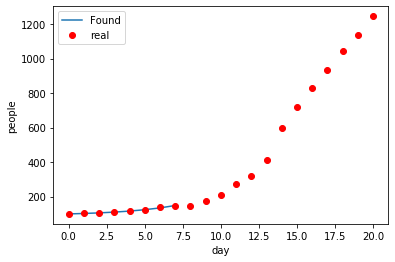

In [217]:
### Fitting
# fit(f_rate_s,meeting_s,Rh_s,Rm_s,Rr_s,day_i,day_f, Normal, Infect, Heal, Net, Found)

# step 1 day 0 to day 7
day_i = 0; day_f = 7
f_rate_s  = np.arange(0.05,0.20,0.05)
meeting_s = np.arange(3,11,1)
Rh_s      = np.arange(0.01,0.03,0.01)
Rm_s      = np.arange(0.1,0.3,0.1)
Rr_s      = np.arange(0.3,0.5,0.1)
params, [MAE, CNormal, CInfect, CHeal, CNet, CFound] = fit(f_rate_s,meeting_s,Rh_s,Rm_s,Rr_s,day_i,day_f, [30E7,10E7,20E7], [0,0,0], [0,0,0], [0,0,0],[0,0,0])



The top 10 best fitted parameters
  MAE  f_rate Meeting  Rh    Rm    Rr
  9.80   0.05  9.0  0.010  0.200  0.300
 11.00   0.05 10.0  0.020  0.100  0.300
 11.88   0.05  6.0  0.020  0.100  0.400
 15.57   0.05  8.0  0.020  0.200  0.300
 16.36   0.10  7.0  0.010  0.100  0.300
 17.30   0.10  4.0  0.020  0.100  0.400
 17.84   0.05  6.0  0.010  0.100  0.400
 17.88   0.10  6.0  0.010  0.200  0.300
 17.90   0.05  5.0  0.020  0.200  0.400
 18.05   0.05  6.0  0.010  0.200  0.400

Plotting for the best fitting
  MAE  f_rate Meeting  Rh    Rm    Rr
  9.80   0.05  9.0  0.010  0.200  0.300


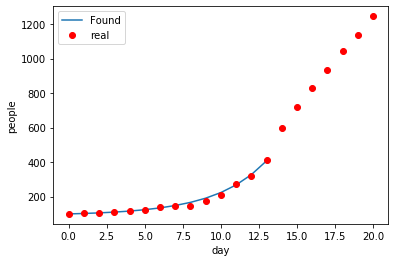

In [218]:
# step 2 day 8 to day 13
day_i = 8; day_f = 13
f_rate_s  = np.arange(0.05,0.20,0.05)
meeting_s = np.arange(3,11,1)
Rh_s      = np.arange(0.01,0.03,0.01)
Rm_s      = np.arange(0.1,0.3,0.1)
Rr_s      = np.arange(0.3,0.5,0.1)
params, [MAE, CNormal, CInfect, CHeal, CNet, CFound] = fit(f_rate_s,meeting_s,Rh_s,Rm_s,Rr_s,day_i,day_f, CNormal, CInfect, CHeal, CNet, CFound)


The top 10 best fitted parameters
  MAE  f_rate Meeting  Rh    Rm    Rr
 65.65   0.25  7.0  0.020  0.200  0.100
 65.95   0.25  4.0  0.020  0.100  0.200
 66.33   0.25  3.0  0.020  0.200  0.200
 67.21   0.20  5.0  0.020  0.100  0.200
 68.91   0.20  4.0  0.010  0.200  0.200
 70.06   0.25  8.0  0.010  0.200  0.100
 70.67   0.20  4.0  0.020  0.200  0.200
 72.74   0.20  9.0  0.010  0.200  0.100
 74.71   0.20  8.0  0.020  0.200  0.100
 76.32   0.15  5.0  0.010  0.200  0.200

Plotting for the best fitting
  MAE  f_rate Meeting  Rh    Rm    Rr
 65.65   0.25  7.0  0.020  0.200  0.100


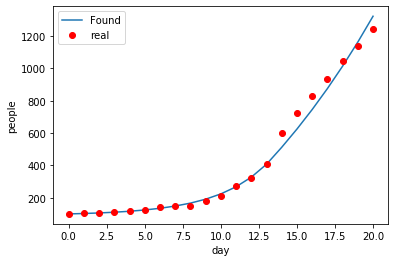

In [219]:
# step 3 day 14 to day 19
day_i = 14; day_f = 20
f_rate_s  = np.arange(0.05,0.3,0.05)
meeting_s = np.arange(3,11,1)
Rh_s      = np.arange(0.01,0.03,0.01)
Rm_s      = np.arange(0.1,0.3,0.1)
Rr_s      = np.arange(0.1,0.5,0.1)
params, [MAE, CNormal, CInfect, CHeal, CNet, CFound] = fit(f_rate_s,meeting_s,Rh_s,Rm_s,Rr_s,day_i,day_f, CNormal, CInfect, CHeal, CNet, CFound)

[65.65221708118622, 0.25, 7, 0.02, 0.2, 0.1]


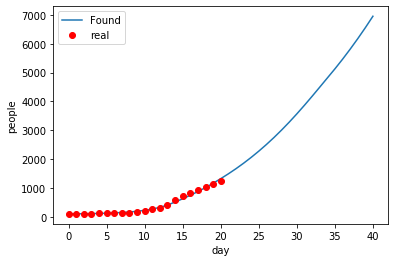

In [228]:
### prediction
day_i = 21; day_f = 40
print(params)
use_last_fitting = True   # True or False
if use_last_fitting:
    ### from last fitting
    f_rate = params[1]
    meeting= params[2]
    Rh     = params[3]
    Rm     = params[4]
    Rr     = params[5]
else:
    ### new input
    f_rate = 0.25
    meeting= 7
    Rh     = 0.02
    Rm     = 0.2
    Rr     = 0.1
_,_,_,_,_ = model(f_rate, meeting, Rh, Rm, Rr, day_i, day_f, CNormal, CInfect, CHeal, CNet, CFound, plot=True, fit=False)

